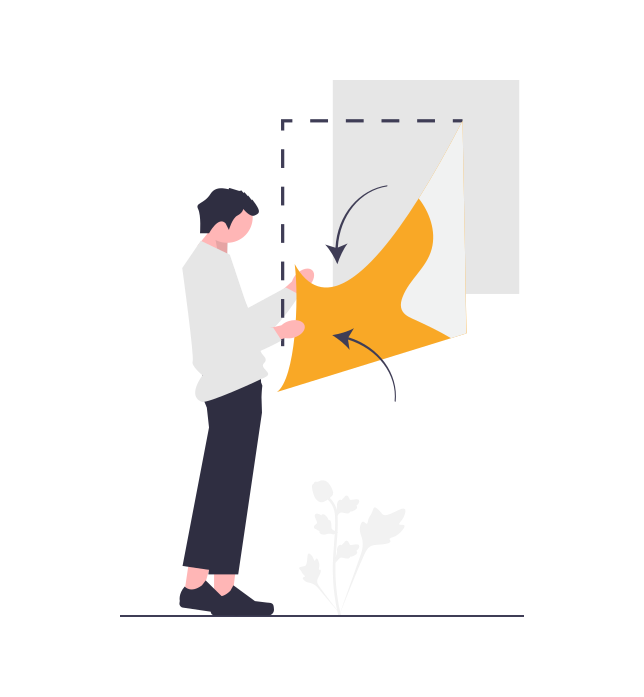

[前回のnotebook](https://www.kaggle.com/code/tsunotsuno/updated-debertav3-lgbm-with-spell-autocorrect)では、DebertaとLGBMのモデルに対して、misspellingを修正する前処理を適用する実験をしていた。<br>
（たくさんのupvoteありがとうございます！notebook expertまであとbronze 1つなのでもうちょっとがんばります！）

In [my previous notebook](https://www.kaggle.com/code/tsunotsuno/updated-debertav3-lgbm-with-spell-autocorrect), I tried to applying pre-processing to correct misspelling before input text into Deberta models.
(Thank you for all the upvotes!)

## Main Concept

現在公開されているDebertaのシングルモデルで最も精度が高いのは、おそらく下記のnotebookの実装である。

https://www.kaggle.com/code/asteyagaur/commonlit-deberta-v3

こちらの実装では私が前回使用したモデルの実装とは大きく異なっており、Debertav3の部分を入れ替えるだけで性能が上がる可能性がある。
今回は、自分の実装におけるDebertaの実装部分をより精度が良いモデルに入れ替えるだけで性能が向上するかを確認する。

So far, the best single model of Deberta is probably the implementation in the notebook below, I think.

https://www.kaggle.com/code/asteyagaur/commonlit-deberta-v3

This implementation is quite different from my previous one, and simply replacing my Debertav3 model with good one may improve performance.
In this notebook, I will check to see if simply replacing the Deberta implementation with a good one will improve performance.

### Feature Engineering

特徴量は前回から変更せず下記の特徴量を使用する。

The features are unchanged from the previous one. I'll use the following features.

[Using features]

- Text Length
- Length Ratio
- Word Overlap
- N-grams Co-occurrence
  - count
  - ratio
- Quotes Overlap
- Grammar Check
  - spelling: pyspellchecker

### Model Archtecture

下記のようなアーキテクチャのモデルを使用して実験する。

I will experiment with the following model of architecture.

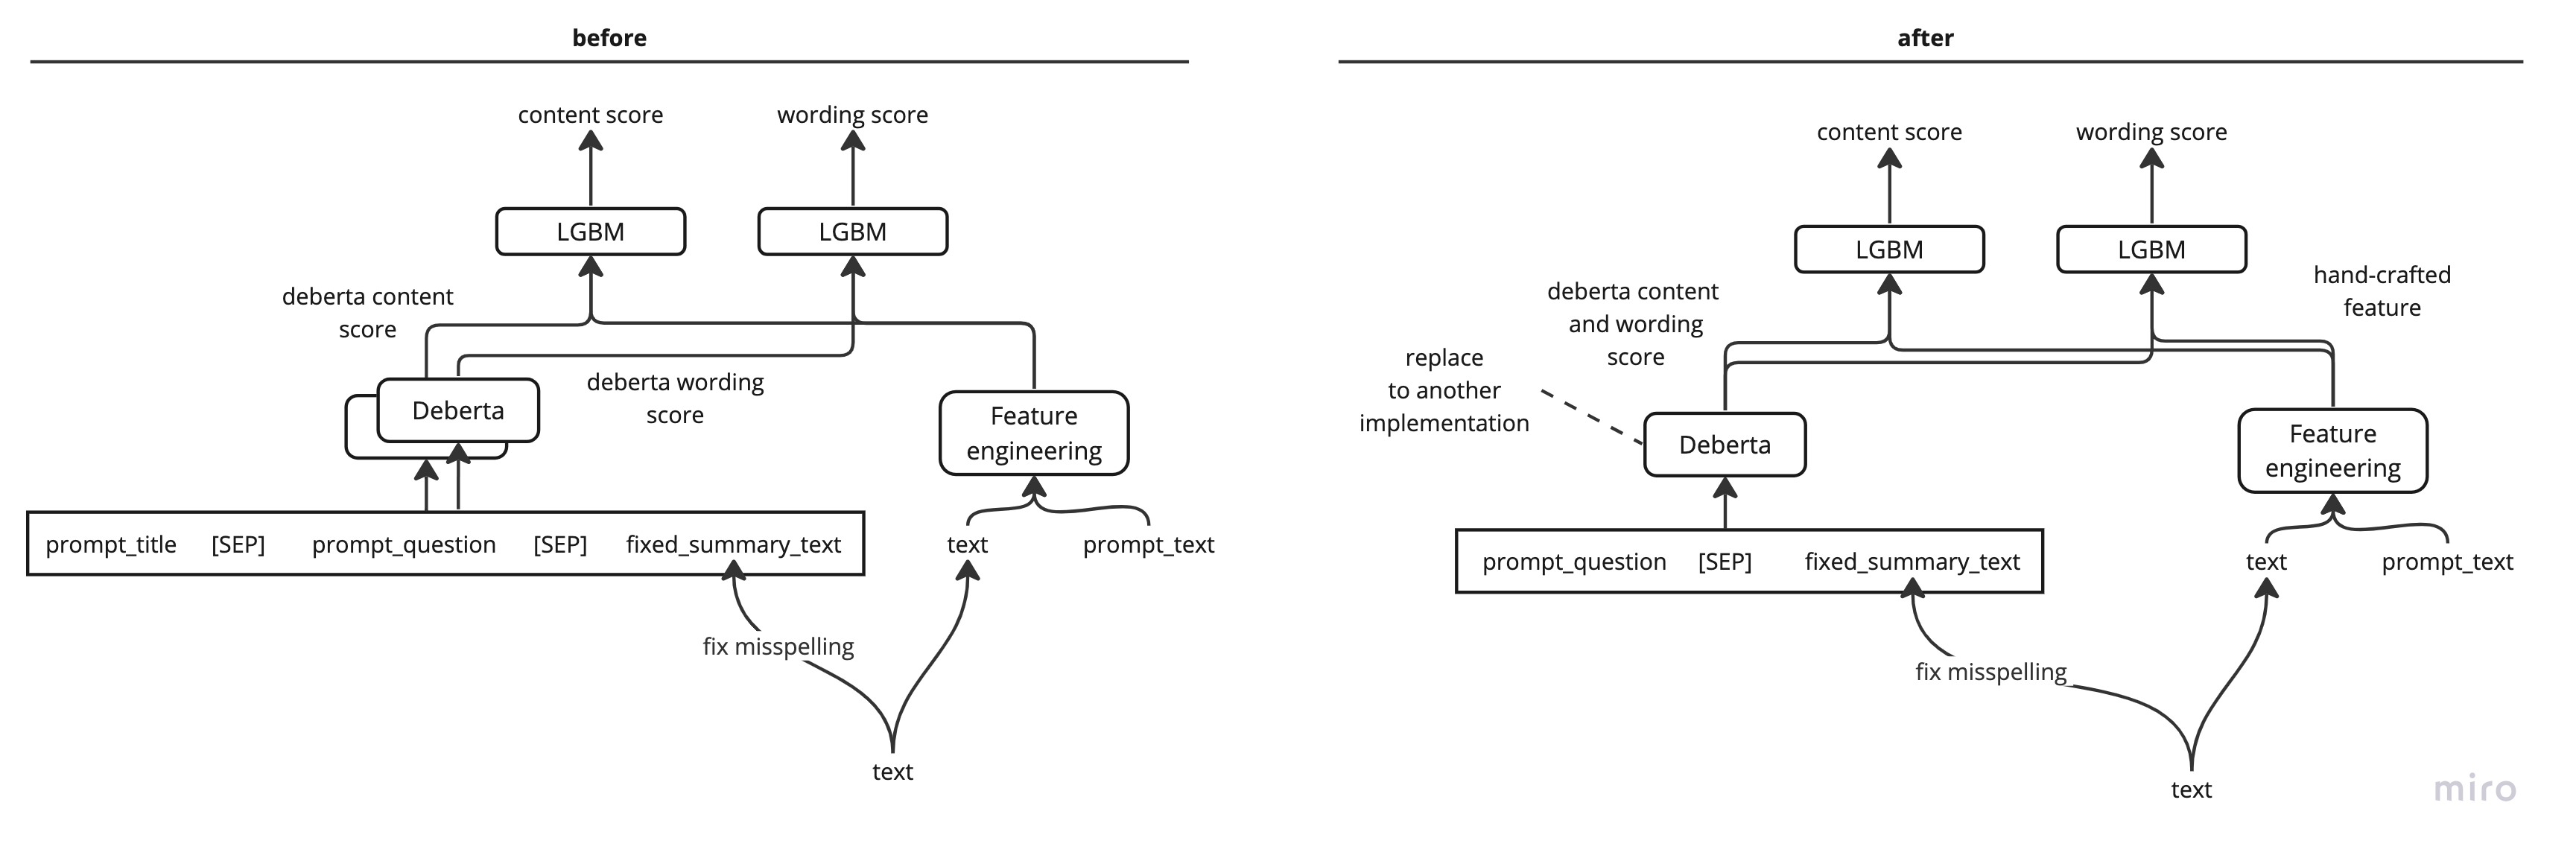

### References

- https://www.kaggle.com/code/asteyagaur/commonlit-deberta-v3
- https://www.kaggle.com/code/asteyagaur/commonlit-inference

### My previous notebooks

- https://www.kaggle.com/code/tsunotsuno/debertav3-baseline-content-and-wording-models
- https://www.kaggle.com/code/tsunotsuno/debertav3-w-prompt-title-question-fields
- https://www.kaggle.com/code/tsunotsuno/debertav3-with-llama2-example
- https://www.kaggle.com/code/tsunotsuno/debertav3-lgbm-with-feature-engineering
- https://www.kaggle.com/code/tsunotsuno/updated-debertav3-lgbm-with-spell-autocorrect


In [1]:
!pip install "/kaggle/input/autocorrect/autocorrect-2.6.1.tar"
!pip install "/kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl"

Processing /kaggle/input/autocorrect/autocorrect-2.6.1.tar
  Preparing metadata (setup.py) ... - \ done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622383 sha256=15f02ceb366fa23c38baa2db89629c12431fc5f6b2f5e89d477483ae880ddfe3
  Stored in directory: /root/.cache/pip/wheels/db/69/42/0fb0421d2fe70d195a04665edc760cfe5fd341d7bb8d8e0aaa
Successfully built autocorrect
Processing /kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl


In [2]:
from typing import Dict, List, Tuple
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import logging
import os
import random
import gc
import shutil
import json
from text_unidecode import unidecode
import codecs
import time
import collections
from termcolor import colored

import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import AdamW, DataCollatorWithPadding
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from transformers import get_polynomial_decay_schedule_with_warmup, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
from transformers.tokenization_utils_base import BatchEncoding, PreTrainedTokenizerBase
from transformers import DataCollatorWithPadding,DataCollatorForTokenClassification

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
from torch.optim import lr_scheduler

from datasets import load_metric, disable_progress_bar
from datasets import Dataset
from datasets import concatenate_datasets, load_dataset, load_from_disk

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import log_loss

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
import spacy
import re
from autocorrect import Speller
from spellchecker import SpellChecker
import lightgbm as lgb


import plotly.express as px #graphing
import plotly.graph_objects as go #graphing
from plotly.subplots import make_subplots #graphing
import plotly.figure_factory as ff #graphing

warnings.simplefilter("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
disable_progress_bar()
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
class cfg:
    select = 'large'
    model_name = f'/kaggle/input/deberta-v3-{select}/deberta-v3-{select}'
    only_model_name = f'deberta-v3-{select}'
    accum_iter = 16
    fold = 4
    seed = 42
    batch_size = 2
    max_len = 1024
    num_epoch = 5
    T_max= 500
    
    scheduler = 'CosineAnnealingLR'
    weight_decay =  1e-6
    min_lr = 1e-6
    freezing = True
    pooling = 'GemText'
    weight_decay = 1e-2
    encoder_lr = 1e-5
    decoder_lr = 1e-5
    eps = 1e-6
    betas = (0.9, 0.999)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]#.detach().to('cpu').numpy()
        y_pred = y_preds[:,i]#.detach().to('cpu').numpy()
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores


def score_loss(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return {
        'mcrmse_score' : mcrmse_score,
        'Content_score' : scores[0],
        'Wording_score' : scores[1]
    }

def get_logger(filename='Training'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    
    # getLogger(__name__) は、現在のモジュールの名前を使用してロガーを取得します
    logger = getLogger(__name__)
    
    # ロガーレベルをINFOに設定します。これにより、INFOレベル以上のログメッセージが記録されます。
    logger.setLevel(INFO)
    
    # コンソール出力用のハンドラを作成し、フォーマッタを設定します
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    
    # ファイル出力用のハンドラを作成し、フォーマッタを設定します
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    
    # ロガーにハンドラを追加します。これにより、ログメッセージはコンソールとファイルの両方に出力されます。
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    
    return logger

LOGGER = get_logger()

# set random seed
def seed_everything(seed: int):
    np.random.seed(seed)
    
    random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(seed=cfg.seed)


LOGGER.info(f"=========================== Model name :{cfg.only_model_name} ===========================: ")
LOGGER.info('\n')
LOGGER.info(f"Scheduler: {cfg.scheduler}")
LOGGER.info(f"batch_size: {cfg.batch_size} with gradient Accumukation {cfg.accum_iter} ")
LOGGER.info(f"Pooling name: {cfg.pooling} ")
LOGGER.info(f"Freezing: {cfg.freezing}")
LOGGER.info(f"Max Length: {cfg.max_len}")
LOGGER.info(f"Num Epochs: {cfg.num_epoch}")
LOGGER.info('\n')

=========================== Model name :deberta-v3-large ===========================: 


Scheduler: CosineAnnealingLR
batch_size: 2 with gradient Accumukation 16 
Pooling name: GemText 
Freezing: True
Max Length: 1024
Num Epochs: 5




## Dataload

In [4]:
DATA_DIR = "/kaggle/input/commonlit-evaluate-student-summaries/"

prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_train = pd.read_csv(DATA_DIR + "summaries_train.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")


summaries_train = summaries_train.head(10) # for dev mode

## Preprocess

[Using features]

- Text Length
- Length Ratio
- Word Overlap
- N-grams Co-occurrence
  - count
  - ratio
- Quotes Overlap
- Grammar Check
  - spelling: pyspellchecker

In [5]:
class Preprocessor:
    def __init__(self) -> None:
        self.twd = TreebankWordDetokenizer()
        self.STOP_WORDS = set(stopwords.words('english'))
        
        self.spacy_ner_model = spacy.load('en_core_web_sm',)
        self.speller = Speller(lang='en')
        self.spellchecker = SpellChecker() 
        
    def word_overlap_count(self, row):
        """ intersection(prompt_text, text) """        
        def check_is_stop_word(word):
            return word in self.STOP_WORDS
        
        prompt_words = row['prompt_tokens']
        summary_words = row['summary_tokens']
        if self.STOP_WORDS:
            prompt_words = list(filter(check_is_stop_word, prompt_words))
            summary_words = list(filter(check_is_stop_word, summary_words))
        return len(set(prompt_words).intersection(set(summary_words)))
            
    def ngrams(self, token, n):
        # Use the zip function to help us generate n-grams
        # Concatentate the tokens into ngrams and return
        ngrams = zip(*[token[i:] for i in range(n)])
        return [" ".join(ngram) for ngram in ngrams]

    def ngram_co_occurrence(self, row, n: int) -> int:
        # Tokenize the original text and summary into words
        original_tokens = row['prompt_tokens']
        summary_tokens = row['summary_tokens']

        # Generate n-grams for the original text and summary
        original_ngrams = set(self.ngrams(original_tokens, n))
        summary_ngrams = set(self.ngrams(summary_tokens, n))

        # Calculate the number of common n-grams
        common_ngrams = original_ngrams.intersection(summary_ngrams)

        # # Optionally, you can get the frequency of common n-grams for a more nuanced analysis
        # original_ngram_freq = Counter(ngrams(original_words, n))
        # summary_ngram_freq = Counter(ngrams(summary_words, n))
        # common_ngram_freq = {ngram: min(original_ngram_freq[ngram], summary_ngram_freq[ngram]) for ngram in common_ngrams}

        return len(common_ngrams)
    
    def ner_overlap_count(self, row, mode:str):
        model = self.spacy_ner_model
        def clean_ners(ner_list):
            return set([(ner[0].lower(), ner[1]) for ner in ner_list])
        prompt = model(row['prompt_text'])
        summary = model(row['text'])

        if "spacy" in str(model):
            prompt_ner = set([(token.text, token.label_) for token in prompt.ents])
            summary_ner = set([(token.text, token.label_) for token in summary.ents])
        elif "stanza" in str(model):
            prompt_ner = set([(token.text, token.type) for token in prompt.ents])
            summary_ner = set([(token.text, token.type) for token in summary.ents])
        else:
            raise Exception("Model not supported")

        prompt_ner = clean_ners(prompt_ner)
        summary_ner = clean_ners(summary_ner)

        intersecting_ners = prompt_ner.intersection(summary_ner)
        
        ner_dict = dict(Counter([ner[1] for ner in intersecting_ners]))
        
        if mode == "train":
            return ner_dict
        elif mode == "test":
            return {key: ner_dict.get(key) for key in self.ner_keys}

    
    def quotes_count(self, row):
        summary = row['text']
        text = row['prompt_text']
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        if len(quotes_from_summary)>0:
            return [quote in text for quote in quotes_from_summary].count(True)
        else:
            return 0

    def spelling(self, text):
        
        wordlist=text.split()
        amount_miss = len(list(self.spellchecker.unknown(wordlist)))

        return amount_miss
    
    def add_spelling_dictionary(self, tokens: List[str]) -> List[str]:
        """dictionary update for pyspell checker and autocorrect"""
        self.spellchecker.word_frequency.load_words(tokens)
        self.speller.nlp_data.update({token:1000 for token in tokens})
    
    def run(self, 
            prompts: pd.DataFrame,
            summaries:pd.DataFrame,
            mode:str
        ) -> pd.DataFrame:
        
        # before merge preprocess
        prompts["prompt_length"] = prompts["prompt_text"].apply(
            lambda x: len(word_tokenize(x))
        )
        prompts["prompt_tokens"] = prompts["prompt_text"].apply(
            lambda x: word_tokenize(x)
        )

        summaries["summary_length"] = summaries["text"].apply(
            lambda x: len(word_tokenize(x))
        )
        summaries["summary_tokens"] = summaries["text"].apply(
            lambda x: word_tokenize(x)
        )
        
        # Add prompt tokens into spelling checker dictionary
        prompts["prompt_tokens"].apply(
            lambda x: self.add_spelling_dictionary(x)
        )
        
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        # fix misspelling
        summaries["fixed_summary_text"] = summaries["text"].progress_apply(
            lambda x: self.speller(x)
        )
        
        # count misspelling
        summaries["splling_err_num"] = summaries["text"].progress_apply(self.spelling)
        
        # merge prompts and summaries
        input_df = summaries.merge(prompts, how="left", on="prompt_id")

        # after merge preprocess
        input_df['length_ratio'] = input_df['summary_length'] / input_df['prompt_length']
        
        input_df['word_overlap_count'] = input_df.progress_apply(self.word_overlap_count, axis=1)
        input_df['bigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence,args=(2,), axis=1 
        )
        input_df['bigram_overlap_ratio'] = input_df['bigram_overlap_count'] / (input_df['summary_length'] - 1)
        
        input_df['trigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence, args=(3,), axis=1
        )
        input_df['trigram_overlap_ratio'] = input_df['trigram_overlap_count'] / (input_df['summary_length'] - 2)
        
        # Crate dataframe with count of each category NERs overlap for all the summaries
        # Because it spends too much time for this feature, I don't use this time.
#         ners_count_df  = input_df.progress_apply(
#             lambda row: pd.Series(self.ner_overlap_count(row, mode=mode), dtype='float64'), axis=1
#         ).fillna(0)
#         self.ner_keys = ners_count_df.columns
#         ners_count_df['sum'] = ners_count_df.sum(axis=1)
#         ners_count_df.columns = ['NER_' + col for col in ners_count_df.columns]
#         # join ner count dataframe with train dataframe
#         input_df = pd.concat([input_df, ners_count_df], axis=1)
        
        input_df['quotes_count'] = input_df.progress_apply(self.quotes_count, axis=1)
        
        return input_df.drop(columns=["summary_tokens", "prompt_tokens"])


preprocessor = Preprocessor()

In [6]:
train = preprocessor.run(prompts_train, summaries_train, mode="train")
test = preprocessor.run(prompts_test, summaries_test, mode="test")

train.head()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,student_id,prompt_id,text,content,wording,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,64,The third wave was an experimental see how peo...,5,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,660,0.096970,14,4,0.063492,0,0.000000,0
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,54,They would rub it up with soda to make the sme...,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",1076,0.050186,18,22,0.415094,10,0.192308,0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,269,"In Egypt, there were many occupations and soci...",32,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,625,0.430400,22,52,0.194030,23,0.086142,2
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,28,The highest class was Pharaohs these people we...,5,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,625,0.044800,6,6,0.222222,5,0.192308,0
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,232,The Third Wave developed rapidly because the ...,29,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,660,0.351515,23,27,0.116883,5,0.021739,4


In [7]:
gkf = GroupKFold(n_splits=cfg.fold)

for i, (_, val_index) in enumerate(gkf.split(train, groups=train["prompt_id"])):
    train.loc[val_index, "fold"] = i

train['fold'] = train['fold'].astype(int)
train.head()

,student_id,prompt_id,text,content,wording,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count,fold
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,64,The third wave was an experimental see how peo...,5,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,660,0.096970,14,4,0.063492,0,0.000000,0,2
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,54,They would rub it up with soda to make the sme...,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",1076,0.050186,18,22,0.415094,10,0.192308,0,0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,269,"In Egypt, there were many occupations and soci...",32,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,625,0.430400,22,52,0.194030,23,0.086142,2,1
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,28,The highest class was Pharaohs these people we...,5,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,625,0.044800,6,6,0.222222,5,0.192308,0,1
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,232,The Third Wave developed rapidly because the ...,29,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,660,0.351515,23,27,0.116883,5,0.021739,4,2


## Model Function Definition

ref: https://www.kaggle.com/code/asteyagaur/commonlit-deberta-v3

In [8]:
tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
class TrainDataset(Dataset):
    """training dataset"""
    def __init__(self, df, tokenizer, max_len:int):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pq = df['prompt_question'].values
        self.text = df['fixed_summary_text'].values
        self.targets = df[['content' , 'wording']].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self , index):

        # input text definition
        pq   =   self.pq[index]
        text =   self.text[index]
        full_text = pq+" " + self.tokenizer.sep_token +" "+text
        
        inputs = self.tokenizer.encode_plus(
                        full_text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        target = self.targets[index]

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
        } , torch.tensor(target, dtype=torch.float)


class TestDataset(Dataset):
    """for only predict dataset"""
    def __init__(self,df, tokenizer, max_len:int):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pq = df['prompt_question'].values
        self.text = df['fixed_summary_text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self , index):
        
        # input text definition
        pq   =   self.pq[index]
        text =   self.text[index]
        full_text = pq + " " + self.tokenizer.sep_token + " " + text
        
        inputs = self.tokenizer.encode_plus(
                        full_text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                        
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        
        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long)
        }
    
def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:, :mask_len]
    return inputs

In [10]:
class GeMText(nn.Module):
    """pooling layer"""
    def __init__(self, dim = 1, p=3, eps=1e-6):
        super(GeMText, self).__init__()
        self.dim = dim
        self.p = Parameter(torch.ones(1) * p)
        self.eps = eps
        self.feat_mult = 1

    def forward(self, last_hidden_state, attention_mask):
        attention_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.shape)
        x = (last_hidden_state.clamp(min=self.eps) * attention_mask_expanded).pow(self.p).sum(self.dim)
        ret = x / attention_mask_expanded.sum(self.dim).clip(min=self.eps)
        ret = ret.pow(1 / self.p)
        return ret

In [11]:
def top_half_layer_freeze(module):
    # Note: When upper layer count is １３, didn't run. (gpu memory exceed)
    # When upper layer count is 18, worked.
    for i in range(0, 18,1):
        for n,p in module.encoder.layer[i].named_parameters():
            p.requires_grad = False

In [12]:
class BaselineModel(nn.Module):
    def __init__(self, model_name ):
        super(BaselineModel, self).__init__()
        
        self.model = AutoModel.from_pretrained(cfg.model_name)
        self.config = AutoConfig.from_pretrained(cfg.model_name)

        #self.drop = nn.Dropout(p=0.2)
        
        # pooling layer
        self.pooler =  GeMText()

        self.fc = nn.Linear(self.config.hidden_size, 2)    
        
        self._init_weights(self.fc)
        
        if cfg.freezing:
            top_half_layer_freeze(self.model)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
           
    def forward(self, ids, mask):
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        #out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [13]:
def train_run(model ,criterion ,optimizer , dataloader):
    
    model.train()
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    running_loss = 0.0
    dataset_size = 0.0 
    
    
    for batch_idx , (data , labels) in bar:
        inputs , target = collate(data) , labels    
        ids  =  inputs['input_ids'].to(cfg.device, dtype = torch.long)
        mask = inputs['attention_mask'].to(cfg.device, dtype = torch.long)
        targets = target.to(cfg.device, dtype = torch.float)
        
        batch_size = ids.size(0)
        outputs = model(ids, mask)
        loss = criterion(outputs, targets)
        
        # normalize loss to account for batch accumulation
        loss = loss / cfg.accum_iter 
        loss.backward()
        
        if ((batch_idx + 1) % cfg.accum_iter == 0) or (batch_idx + 1 == len(dataloader)):
            optimizer.step()
            optimizer.zero_grad()
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

    epoch_loss = running_loss/dataset_size
    gc.collect()
    
    return epoch_loss

In [14]:
@torch.no_grad()
def valid_run(model , dataloader):
    model.eval()
    
    running_loss = 0.0
    dataset_size = 0.0
    
    predictions = []
    y_labels = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for batch_idx , (data , labels) in bar:
        inputs , target = collate(data) , labels
        ids  =  inputs['input_ids'].to(cfg.device, dtype = torch.long)
        mask = inputs['attention_mask'].to(cfg.device, dtype = torch.long)
        targets = target.to(cfg.device, dtype = torch.float)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        predictions.append(outputs.detach().to('cpu').numpy())
        y_labels.append(labels.detach().to('cpu').numpy())
    
    predictions = np.concatenate(predictions)
    y_labels    = np.concatenate(y_labels)
    epoch_loss = running_loss / dataset_size
    gc.collect()   
    
    return epoch_loss , predictions , y_labels
        

In [15]:
@torch.no_grad()
def test_run(model , loader):
    
    model.eval()
       
    preds = []
    bar = tqdm(enumerate(loader), total=len(loader))
    for idx , data in bar:
        inputs = collate(data)
        ids   =  inputs['input_ids'].to(cfg.device, dtype = torch.long)
        mask  =  inputs['attention_mask'].to(cfg.device, dtype = torch.long)
        y_preds = model(ids , mask)
        preds.append(y_preds.to('cpu').numpy())
    
    predictions = np.concatenate(preds)
    
    return predictions
   

In [16]:
def prepare_fold(fold):
    
    dftrain = train[train['fold'] != n_fold]
    dfvalid = train[train['fold'] == n_fold]
    
    train_dataset = TrainDataset(dftrain, tokenizer=tokenizer, max_len=cfg.max_len)
    valid_dataset = TrainDataset(dfvalid, tokenizer=tokenizer, max_len=cfg.max_len)
    
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, num_workers=2, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=cfg.batch_size, num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader , valid_loader
    

In [17]:
def oof_df(n_fold , true , pred):
    
    df_pred = pd.DataFrame(pred ,columns= ['pred_content' , 'pred_wording'] )
    df_real = pd.DataFrame(true ,columns= ['content' , 'wording'] )
    
    df = pd.concat([df_real , df_pred ],axis=1)

    return df

In [18]:
def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
              'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
              'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
              'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters


In [19]:
oof_dfs = []
for n_fold in range(cfg.fold):
    LOGGER.info('\n')
    LOGGER.info(f"========== fold: {n_fold} training ==========")
    train_loader, valid_loader = prepare_fold(fold=n_fold)
    LOGGER.info(f'Number of batches in Train {len(train_loader) } and valid {len(valid_loader)} dataset')
    model  = BaselineModel(cfg.model_name).to(cfg.device)   
    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=cfg.encoder_lr, 
                                                decoder_lr=cfg.decoder_lr,
                                                weight_decay=cfg.weight_decay)

    optimizer = AdamW(optimizer_parameters, lr=cfg.encoder_lr, eps=cfg.eps, betas=cfg.betas)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=cfg.T_max, 
                                                   eta_min=cfg.min_lr)
   
    criterion = nn.SmoothL1Loss(reduction='mean')
    
    start = time.time()
    best_epoch_score = np.inf
    for epoch in range(cfg.num_epoch):
        
        train_loss  = train_run(model ,criterion ,optimizer , dataloader=train_loader)
        valid_loss , valid_preds , valid_labels  = valid_run(model , dataloader=valid_loader)
        
        if valid_loss < best_epoch_score:
            
            LOGGER.info(f"Validation Loss Improved ({best_epoch_score} ---> {valid_loss})")
            best_epoch_score = valid_loss
            ### saving weights
            torch.save(model.state_dict(), f"{cfg.only_model_name}_Fold_{n_fold}.pth") 
            
            ## saving oof values
            df_ = oof_df(n_fold , valid_labels , valid_preds)
            
            LOGGER.info(f'Weights and oof values saved for epochs-{epoch} .....')
            
        LOGGER.info(f"Epoch {epoch} Training Loss {np.round(train_loss , 4)} Validation Loss {np.round(valid_loss , 4)}")
    
        
    end = time.time()
    time_elapsed = end - start
    
    LOGGER.info(' Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    
    LOGGER.info(" Best Loss: {:.4f}".format(best_epoch_score))
    
    oof_dfs.append(df_)            
    LOGGER.info(f" oof for fold {n_fold} ---> {score_loss(valid_labels, valid_preds )}")

    del model, train_loader, valid_loader , df_ , valid_preds , valid_labels
    gc.collect()
    LOGGER.info('\n')




========== fold: 0 training ==========
Number of batches in Train 4 and valid 2 dataset
Some weights of the model checkpoint at /kaggle/input/deberta-v3-large/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initi

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss Improved (inf ---> 0.4424586196740468)
Weights and oof values saved for epochs-0 .....
Epoch 0 Training Loss 0.0582 Validation Loss 0.4425


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss Improved (0.4424586196740468 ---> 0.4183210531870524)
Weights and oof values saved for epochs-1 .....
Epoch 1 Training Loss 0.0567 Validation Loss 0.4183


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss Improved (0.4183210531870524 ---> 0.40159714221954346)
Weights and oof values saved for epochs-2 .....
Epoch 2 Training Loss 0.0547 Validation Loss 0.4016


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss Improved (0.40159714221954346 ---> 0.38040052851041156)
Weights and oof values saved for epochs-3 .....
Epoch 3 Training Loss 0.0532 Validation Loss 0.3804


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss Improved (0.38040052851041156 ---> 0.35840558012326557)
Weights and oof values saved for epochs-4 .....
Epoch 4 Training Loss 0.0511 Validation Loss 0.3584
 Training complete in 0h 0m 45s
 Best Loss: 0.3584
 oof for fold 0 ---> {'mcrmse_score': 0.8740496, 'Content_score': 0.89094585, 'Wording_score': 0.85715336}




========== fold: 1 training ==========
Number of batches in Train 4 and valid 2 dataset
Some weights of the model checkpoint at /kaggle/input/deberta-v3-large/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializi

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss Improved (inf ---> 1.1843114097913106)
Weights and oof values saved for epochs-0 .....
Epoch 0 Training Loss 0.0368 Validation Loss 1.1843


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss Improved (1.1843114097913106 ---> 1.1679243445396423)
Weights and oof values saved for epochs-1 .....
Epoch 1 Training Loss 0.0354 Validation Loss 1.1679


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss Improved (1.1679243445396423 ---> 1.1548465266823769)
Weights and oof values saved for epochs-2 .....
Epoch 2 Training Loss 0.034 Validation Loss 1.1548


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss Improved (1.1548465266823769 ---> 1.138407734533151)
Weights and oof values saved for epochs-3 .....
Epoch 3 Training Loss 0.0325 Validation Loss 1.1384


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss Improved (1.138407734533151 ---> 1.1220107525587082)
Weights and oof values saved for epochs-4 .....
Epoch 4 Training Loss 0.0317 Validation Loss 1.122
 Training complete in 0h 0m 41s
 Best Loss: 1.1220
 oof for fold 1 ---> {'mcrmse_score': 2.1849794, 'Content_score': 1.8986222, 'Wording_score': 2.4713368}




========== fold: 2 training ==========
Number of batches in Train 4 and valid 1 dataset
Some weights of the model checkpoint at /kaggle/input/deberta-v3-large/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing Deb

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Validation Loss Improved (inf ---> 1.1738803386688232)
Weights and oof values saved for epochs-0 .....
Epoch 0 Training Loss 0.0408 Validation Loss 1.1739


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 Training Loss 0.0381 Validation Loss 1.1992


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2 Training Loss 0.0354 Validation Loss 1.2263


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3 Training Loss 0.0338 Validation Loss 1.254


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4 Training Loss 0.0315 Validation Loss 1.2812
 Training complete in 0h 0m 15s
 Best Loss: 1.1739
 oof for fold 2 ---> {'mcrmse_score': 2.154714, 'Content_score': 2.1057847, 'Wording_score': 2.2036438}




========== fold: 3 training ==========
Number of batches in Train 4 and valid 1 dataset
Some weights of the model checkpoint at /kaggle/input/deberta-v3-large/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Validation Loss Improved (inf ---> 0.183912992477417)
Weights and oof values saved for epochs-0 .....
Epoch 0 Training Loss 0.056 Validation Loss 0.1839


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 Training Loss 0.0536 Validation Loss 0.2015


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2 Training Loss 0.0513 Validation Loss 0.2229


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3 Training Loss 0.0494 Validation Loss 0.2482


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4 Training Loss 0.0474 Validation Loss 0.2769
 Training complete in 0h 0m 16s
 Best Loss: 0.1839
 oof for fold 3 ---> {'mcrmse_score': 0.7292657, 'Content_score': 0.8926318, 'Wording_score': 0.5658995}




## Predict for train data

In [20]:
tmp_df = pd.DataFrame()

for n_fold in range(cfg.fold):
    LOGGER.info('\n')
    LOGGER.info(f"========== fold: {n_fold} predict for cv ==========")

    dfvalid = train[train['fold'] == n_fold]
    valid_dataset = TestDataset(dfvalid, tokenizer=tokenizer, max_len=cfg.max_len)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=cfg.batch_size, 
                              num_workers=2, 
                              shuffle=False, 
                              pin_memory=True
                             )
    
    LOGGER.info(f'Number of batches in valid {len(valid_loader)} dataset')

    model  = BaselineModel(cfg.model_name).to(cfg.device)   
    model.load_state_dict(torch.load(f"{cfg.only_model_name}_Fold_{n_fold}.pth", map_location=torch.device('cpu')))
    
    #model.load_state_dict(torch.load(f"/kaggle/input/commonlit-deberta-hidden-layers-mean/deberta-v3-base_Fold_{fold}.pth", map_location=torch.device('cpu')))
    preds = test_run(model, valid_loader)
    
    dfvalid[['content_pred' , 'wording_pred']] = preds
    tmp_df = pd.concat([tmp_df, dfvalid])
    
    del model ; gc.collect()
    torch.cuda.empty_cache()

train = tmp_df



========== fold: 0 predict for cv ==========
Number of batches in valid 2 dataset
Some weights of the model checkpoint at /kaggle/input/deberta-v3-large/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializin

  0%|          | 0/2 [00:00<?, ?it/s]



========== fold: 1 predict for cv ==========
Number of batches in valid 2 dataset
Some weights of the model checkpoint at /kaggle/input/deberta-v3-large/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializin

  0%|          | 0/2 [00:00<?, ?it/s]



========== fold: 2 predict for cv ==========
Number of batches in valid 1 dataset
Some weights of the model checkpoint at /kaggle/input/deberta-v3-large/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializin

  0%|          | 0/1 [00:00<?, ?it/s]



========== fold: 3 predict for cv ==========
Number of batches in valid 1 dataset
Some weights of the model checkpoint at /kaggle/input/deberta-v3-large/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializin

  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
train

,student_id,prompt_id,text,content,wording,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,...,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count,fold,content_pred,wording_pred
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,54,They would rub it up with soda to make the sme...,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,...,0.050186,18,22,0.415094,10,0.192308,0,0,0.350407,0.482282
5,0071d51dab6d,ebad26,They would use chemicals and substances to cha...,0.205683,0.380538,45,They would use chemicals and substances to cha...,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,...,0.041822,7,1,0.022727,0,0.000000,0,0,0.430668,0.502838
7,00746c7c79c3,ebad26,"Many times the factories would, according to t...",-0.878889,-0.966330,51,"Many times the factories would, according to t...",6,Summarize the various ways the factory would u...,Excerpt from The Jungle,...,0.047398,14,14,0.280000,8,0.163265,0,0,0.355232,0.513055
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,269,"In Egypt, there were many occupations and soci...",32,"In complete sentences, summarize the structure...",Egyptian Social Structure,...,0.430400,22,52,0.194030,23,0.086142,2,1,-0.141283,-0.012048
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,28,The highest class was Pharaohs these people we...,5,"In complete sentences, summarize the structure...",Egyptian Social Structure,...,0.044800,6,6,0.222222,5,0.192308,0,1,-0.185110,-0.051117
6,0072b649a88c,3b9047,The Egyptian society is really different from ...,0.205683,0.380538,82,The Egyptian society is really different from ...,7,"In complete sentences, summarize the structure...",Egyptian Social Structure,...,0.131200,13,7,0.086420,0,0.000000,0,1,-0.139806,0.005711
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,64,The third wave was an experimental see how peo...,5,Summarize how the Third Wave developed over su...,The Third Wave,...,0.096970,14,4,0.063492,0,0.000000,0,2,0.431326,0.254288
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,232,The Third Wave developed rapidly because the ...,29,Summarize how the Third Wave developed over su...,The Third Wave,...,0.351515,23,27,0.116883,5,0.021739,4,2,0.609065,0.221492
8,00791789cc1f,39c16e,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415,59,1 element of an ideal tragedy is that it shoul...,3,Summarize at least 3 elements of an ideal trag...,On Tragedy,...,0.084406,12,13,0.224138,4,0.070175,0,3,0.256323,-0.214804
9,0086ef22de8f,39c16e,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058,30,The three elements of an ideal tragedy are: H...,4,Summarize at least 3 elements of an ideal trag...,On Tragedy,...,0.042918,10,2,0.068966,0,0.000000,0,3,0.108538,-0.244214


In [22]:
targets = ["content", "wording"]
    
rmses = []

for target in targets:
    preds = train[target + "_pred"]
    trues = train[target]
        
    rmse = np.sqrt(mean_squared_error(trues, preds))
    print(f"{target}_rmse : {rmse}")
    rmses = rmses + [rmse]

print(f"mcrmse : {sum(rmses) / len(rmses)}")

content_rmse : 1.473917884755417
wording_rmse : 1.721275939183421
mcrmse : 1.5975969119694189


In [23]:
train.to_csv('train_large.csv',index=False)